# Model multi-variabel (PART III)

## Kurva Transmisi Filter

In [1]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook'])

import scipy.special as sc
import pandas as pd
import pymc as pm
import arviz as az
# az.style.use("arviz-darkgrid")
import corner

import aesara
import aesara.tensor as at
from aesara.compile.ops import as_op

Pada contoh kasus kali ini, kita ambil kurva transmisi dari Bessel R.

In [2]:
df = pd.read_csv('Bessel_R-1.txt', delimiter='\t', header=None)
df.head()

,0,1,2
0,1100.0,NaN,-0.006645
1,1099.5,NaN,-0.008312
2,1099.0,NaN,-0.006417
3,1098.5,NaN,-0.009574
4,1098.0,NaN,-0.006094


Ambil kolom yang diperlukan (dalam hal ini adalah kolom 0 dan 2), *rename*, dan hapus `NaN`

In [3]:
data = df[[0, 2]]
data.columns = ['wavelength','percentage']
data = data.dropna(axis=0)

data['percentage'].head()

0   -0.006645
1   -0.008312
2   -0.006417
3   -0.009574
4   -0.006094
Name: percentage, dtype: float64

Lakukan interpolasi dan *drop* yang mengandung `NaN`

In [4]:
from scipy.interpolate import interp1d

data_clean = data.dropna(axis=1)
data_clean

,wavelength,percentage
0,1100.0,-0.006645
1,1099.5,-0.008312
2,1099.0,-0.006417
3,1098.5,-0.009574
4,1098.0,-0.006094
...,...,...
1796,202.0,0.000249
1797,201.5,-0.000679
1798,201.0,-0.001274
1799,200.5,-0.000756


In [5]:
data['wavelength'] = data_clean['wavelength'].astype('float') # pastikan kolom wavelength dalam float
data['transmissivity'] = data_clean['percentage']/100.
data.head()

,wavelength,percentage,transmissivity
0,1100.0,-0.006645,-0.000066
1,1099.5,-0.008312,-0.000083
2,1099.0,-0.006417,-0.000064
3,1098.5,-0.009574,-0.000096
4,1098.0,-0.006094,-0.000061


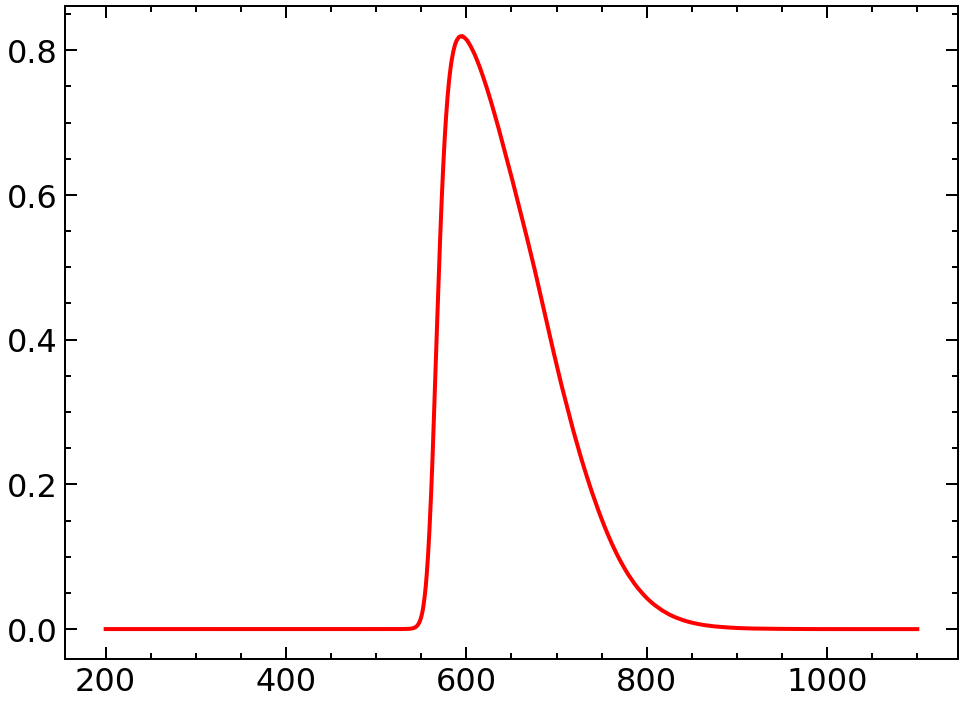

In [6]:
x = data['wavelength']
y = data['transmissivity']
plt.plot(x, y, 'r')

Interpolasi 1D untuk titik - titik data di atas.

In [7]:
f_interp = interp1d(x, y, kind='cubic')

In [8]:
x_dense = np.linspace(500, 900, 100)
y_dense = f_interp(x_dense)

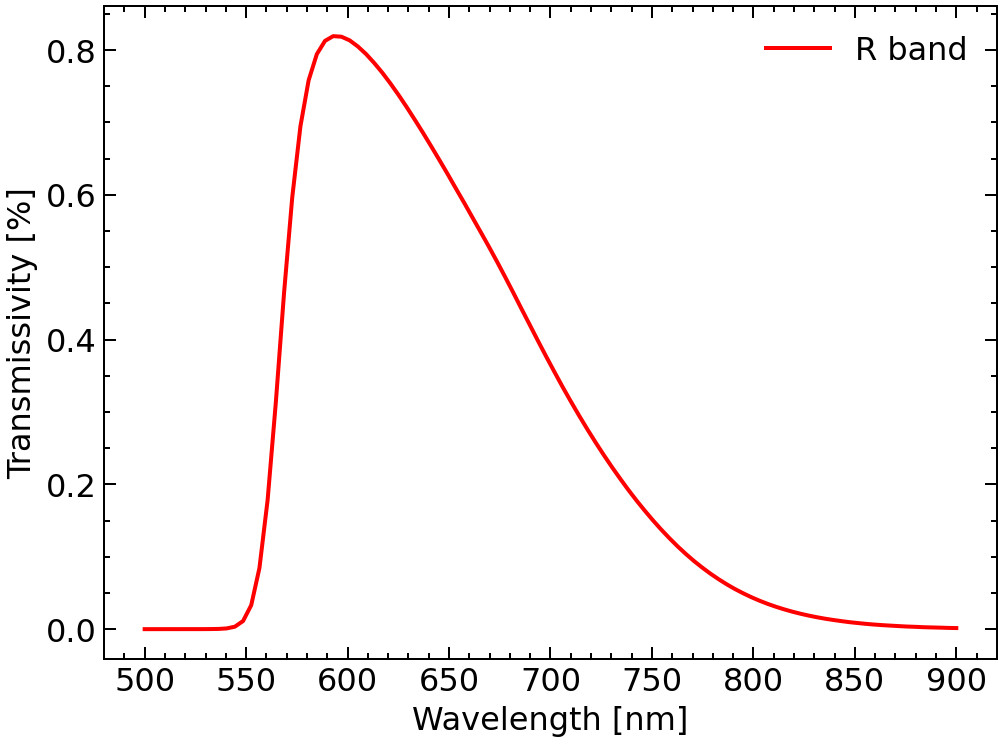

In [9]:
plt.plot(x_dense, y_dense, 'r', label='R band')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmissivity [%]')
plt.legend()
plt.savefig('r-band.png', dpi=150)

## *Blackbody Curve*

In [10]:
from astropy.modeling.models import BlackBody
import astropy.units as u

In [11]:
temperature = 5800 * u.K # temperatur bintang
bandwidth = np.arange(530, 901, 10)

x_axis = np.arange(200, 2000) * u.nm # rentang panjang gelombang yang ditinjau (nanti disesuaikan dengan bandwidth)
x_axis2 = np.arange(530, 901) * u.nm
pita = bandwidth * u.nm

In [12]:
bb = BlackBody(temperature=temperature)
# denum = np.max(bb(x_axis)) # faktor normalisasi supaya nilai pada λ puncak maksimum 1
bb_results = bb(x_axis)
bb_results2 = bb(x_axis2)

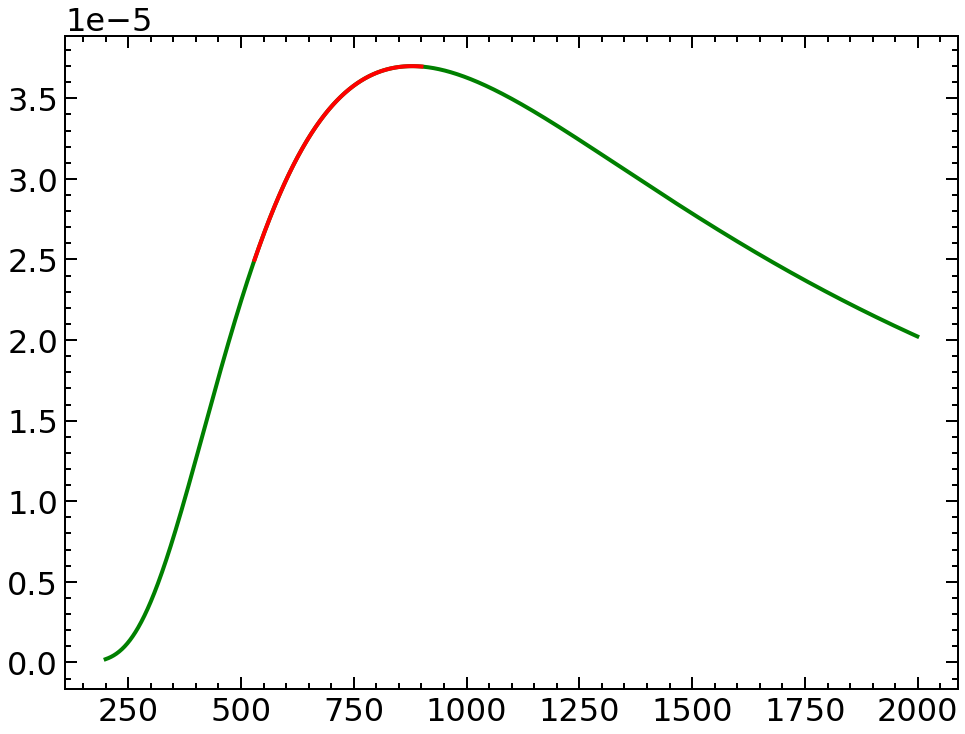

In [13]:
plt.plot(x_axis, bb_results, 'g-')
plt.plot(x_axis2, bb_results2, 'r-', lw=2)

## *Blackbody Curve* II

In [14]:
def Planck(λ, T): 
    """
    λ: dalam cm
    T: dalam K
    """
    a = 3.7412e-5 / ((λ * 1e-7) **5) # 1e-7 adalah konversi dari nm ke cm
    b = np.exp(1.43879/(λ * 1e-7 * T)) - 1
    return a/b

In [15]:
def NormData(data):
    return (data - np.min(data))/(np.max(data) - np.min(data))

In [16]:
x_val = x_axis.value
y_val = Planck(x_val, 5800)
y_val

array([4.79900306e+13, 4.97875083e+13, 5.16271522e+13, ...,
       4.78208139e+13, 4.77429822e+13, 4.76653057e+13])

In [17]:
den = np.max(y_val)
y_fin = y_val/den
# y_fin = NormData(y_val)

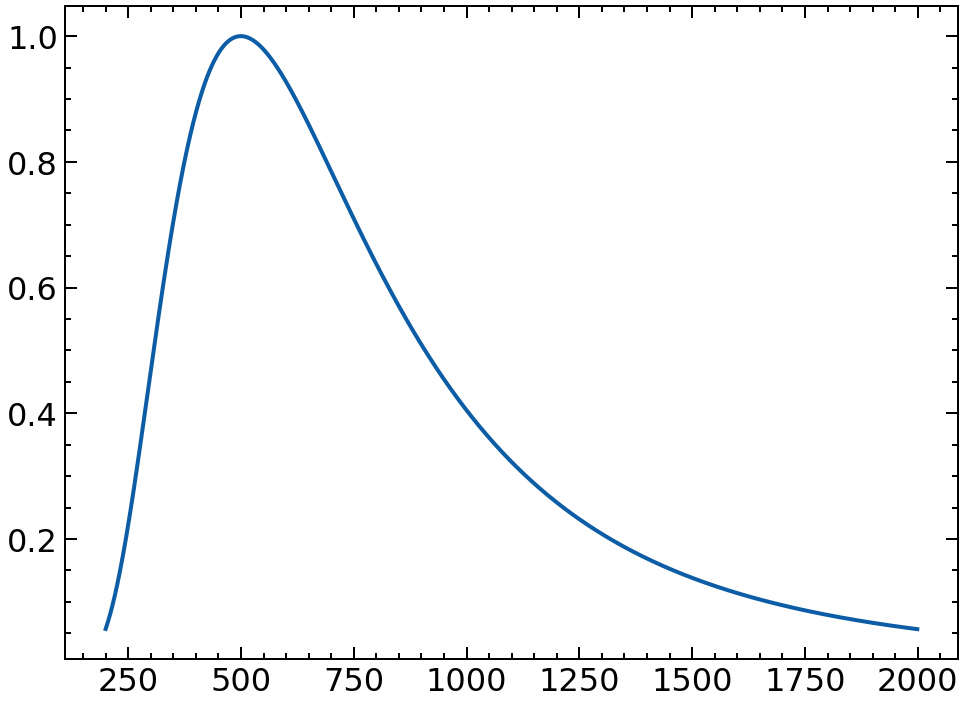

In [18]:
plt.plot(x_axis, y_fin)

In [19]:
bandwidth = np.arange(530, 901, 10) # rentang sesuai kurva transmisi

bandwidth

array([530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650,
       660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780,
       790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900])

In [20]:
y_bandwidth = Planck(bandwidth, 5800)

y_fin_bandwidth = y_bandwidth/den
# y_fin_bandwidth = (y_bandwidth - np.min(y_val))/(np.max(y_val) - np.min(y_val))

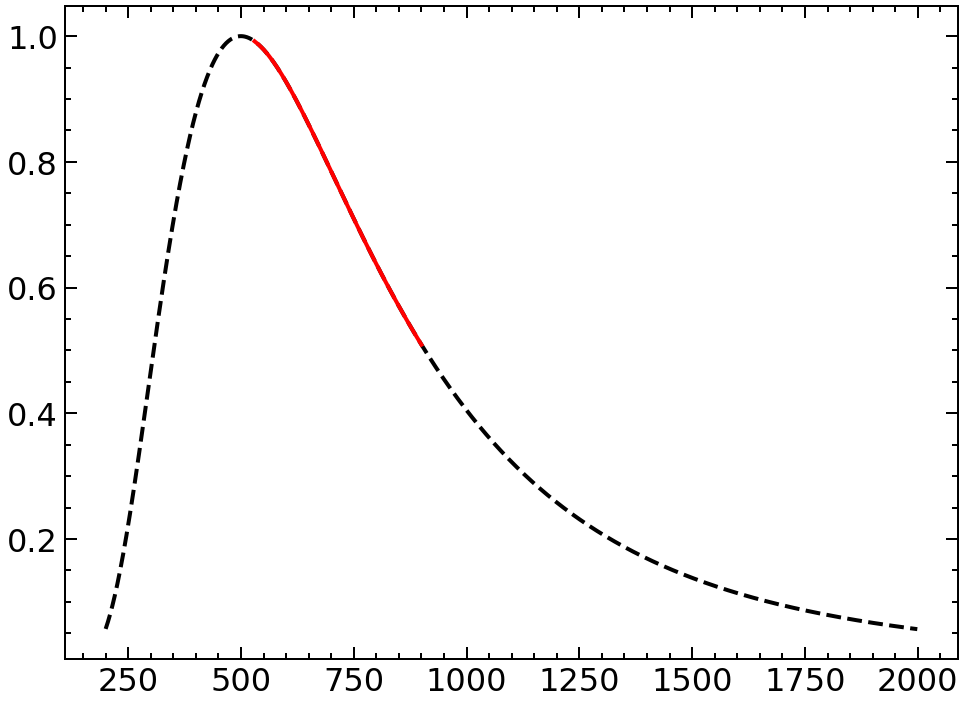

In [21]:
plt.plot(x_axis, y_fin, 'k--')
plt.plot(bandwidth, y_fin_bandwidth, 'r-')
plt.savefig('planck-5800.png', dpi=150)

## Siapkan data sintetik dan model

In [22]:
x_data = np.linspace(-100, 100, 500)

In [23]:
# -------------------------
# pre-determined variables
# -------------------------
d_moon = 374348.01497938664 # satuan km
x0 = 0.
A = 1000.
σ_true = 250.
T = 5800.

In [24]:
# def fresnel_monokromatik(x, x0, d, A):
#     w = (x - x0) * np.sqrt(2 / (550 * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
#     cc, ss = sc.fresnel(w)
#     y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
#     return y

def fresnel_polikromatik(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp(bandwidth[i]) * (Planck(bandwidth[i], T)/den) * y
        y0 += y_new
    return y0

In [25]:
y_data = fresnel_polikromatik(x_data, x0, d_moon, A)
# y_data_mono = fresnel_monokromatik(x_data, x0, d_moon, A)
y_data = np.random.normal(y_data, scale=σ_true)

y_data_scaled = y_data / (y_data.std()*2)

Text(0, 0.5, 'Intensity')

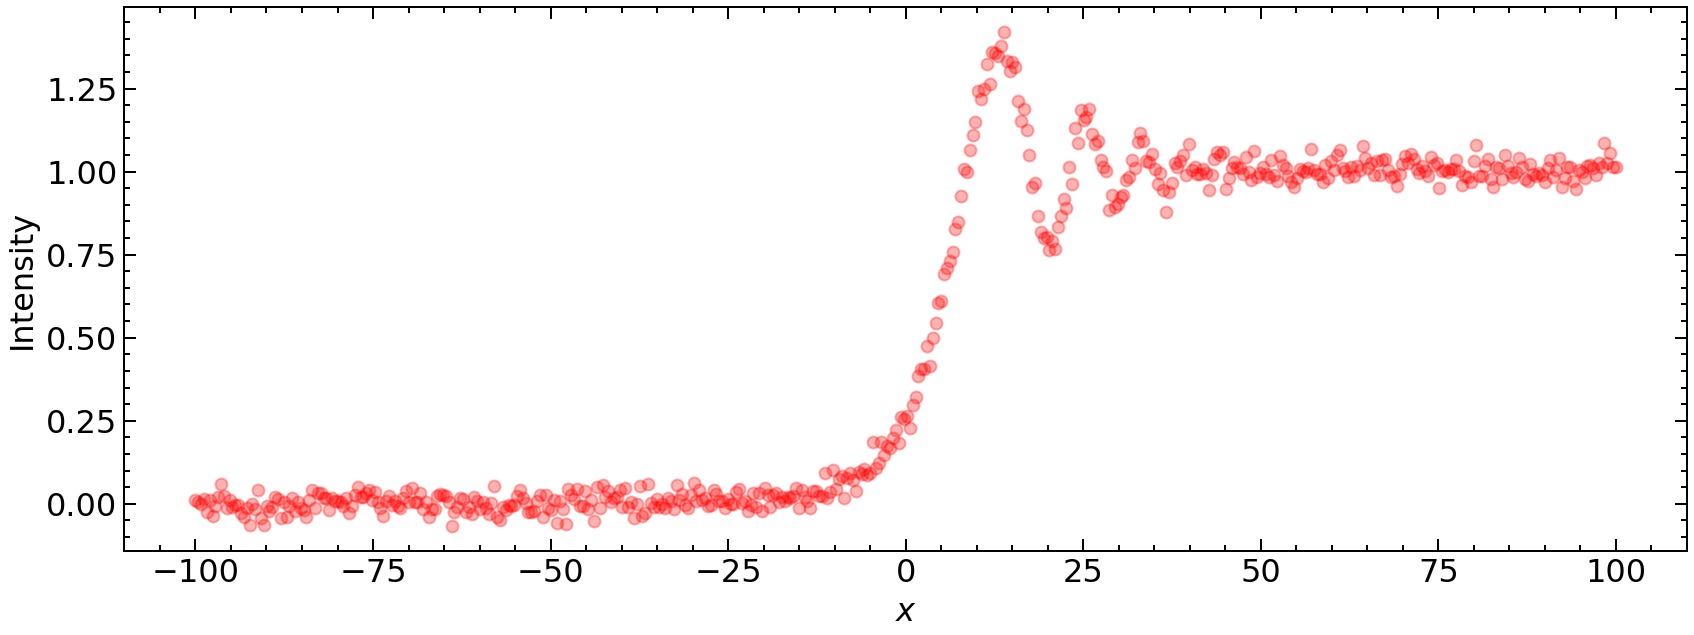

In [26]:
plt.figure(figsize = (14,5), facecolor='w')
plt.scatter(x_data, y_data_scaled, marker='o', c='r', alpha=0.3)
# plt.plot(x_data, y_data, 'r-', lw=1)
# plt.plot(x_data, y_data_mono, 'b-', lw=1)
plt.xlabel(r'$x$')
plt.ylabel('Intensity')

In [27]:
@as_op(itypes=[at.dvector, at.dscalar, at.dscalar, at.dscalar], otypes=[at.dvector])
def t_fresnel_polikromatik(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp(bandwidth[i]) * (Planck(bandwidth[i], T)/den) * y
        # y_new = f_interp(bandwidth[i]) * y
        y0 += y_new
    return y0

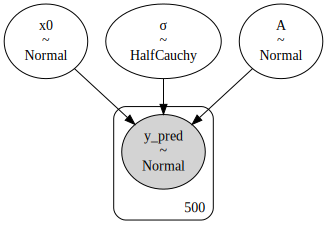

In [28]:
x_shared = aesara.shared(x_data)
d_shared = aesara.shared(d_moon)

with pm.Model() as model_polikromatik:
    A = pm.Normal('A', mu=1., sigma=0.5)
    σ = pm.HalfCauchy('σ', beta=1.)
    x0 = pm.Normal('x0', mu=0., sigma=2.)
    
    μ = t_fresnel_polikromatik(x_shared, x0, d_shared, A)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=y_data_scaled)
    
pm.model_to_graphviz(model_polikromatik)

In [29]:
with model_polikromatik:
    idata = pm.sample(cores=1)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Slice: [A]
>>Slice: [x0]
>NUTS: [σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 243 seconds.


array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'x0'}>,
        <AxesSubplot:title={'center':'x0'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

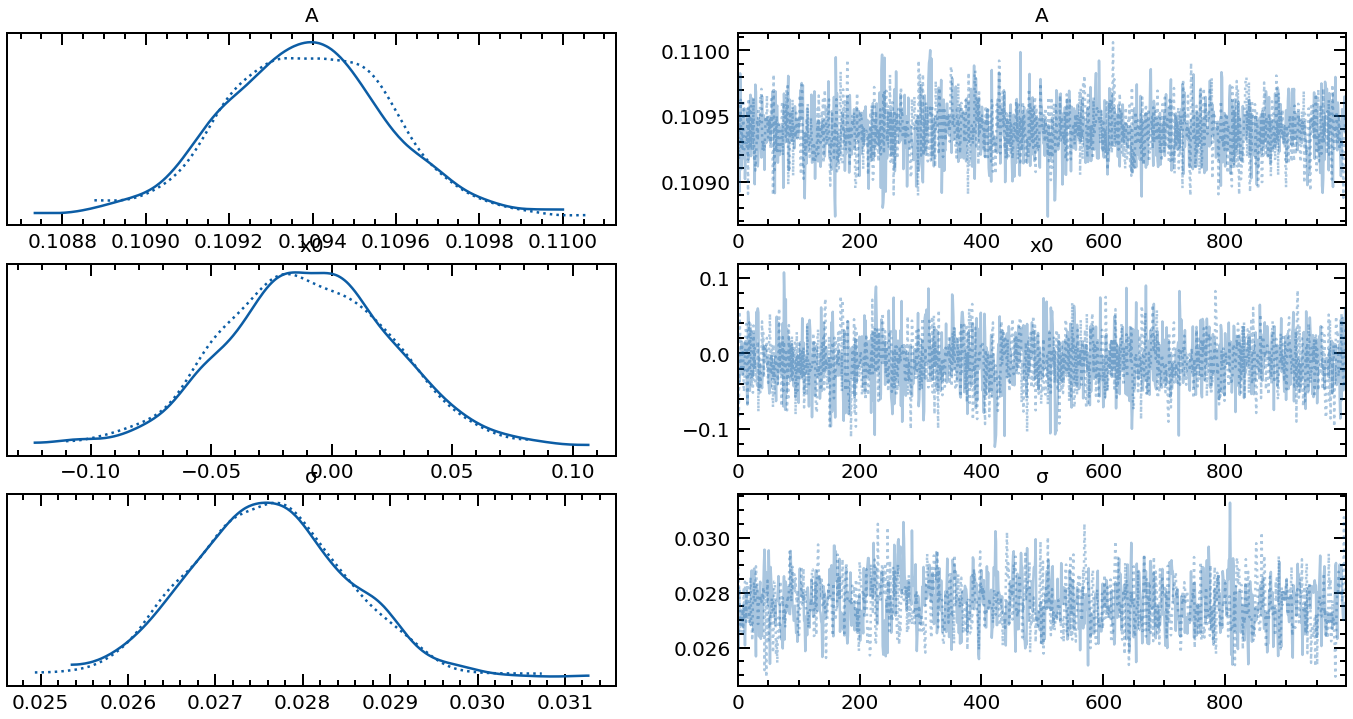

In [30]:
az.plot_trace(idata)

In [31]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,0.109,0.000,0.109,0.110,0.000,0.000,1949.0,1475.0,1.0
x0,-0.010,0.034,-0.071,0.055,0.001,0.001,1711.0,1373.0,1.0
σ,0.028,0.001,0.026,0.029,0.000,0.000,850.0,1386.0,1.0


In [32]:
# chain_count =  trace.posterior.stack(sample=("chain", "draw")).σ.values.shape[0]
# y_pred_g = pm.sample_posterior_predictive(trace, samples=chain_count, model=model_polikromatik)
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [33]:
idata_pp = idata.posterior_predictive

idata_pp_st = idata_pp.stack(sample=("chain", "draw"))

crit_l = np.percentile(idata_pp_st['y_pred'], 2.5, axis=1)  # 2.5% persentil 
crit_u = np.percentile(idata_pp_st['y_pred'], 97.5, axis=1)  # 97.5% persentil
mean_spp = np.mean(idata_pp_st['y_pred'], axis=1) # Median

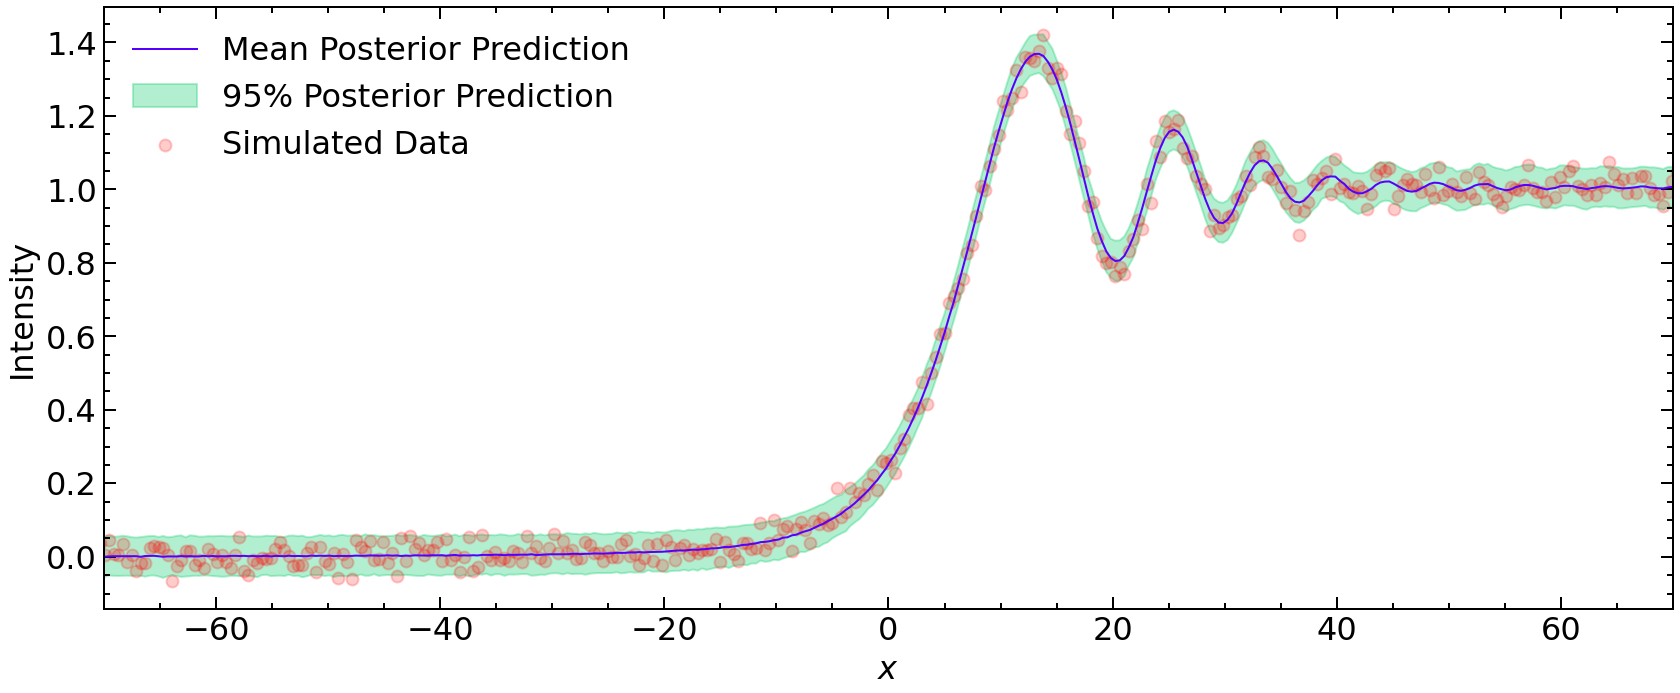

In [34]:
plt.figure(figsize=(12,5))
plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data, crit_l, crit_u, alpha=0.3, color="#00cc66")
plt.scatter(x_data, y_data_scaled, c='r', marker='o', alpha=0.2)
# plt.plot(x_data2, y_data2, 'r-', lw=1, alpha=0.5)
plt.xlim(-70, 70)
plt.xlabel(r'$x$')
plt.ylabel('Intensity')
plt.tight_layout()
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'], loc='upper left')
plt.savefig('hasil-kurvatransmisi-planck.png', dpi=150)

<AxesSubplot:xlabel='y_pred / y_pred'>

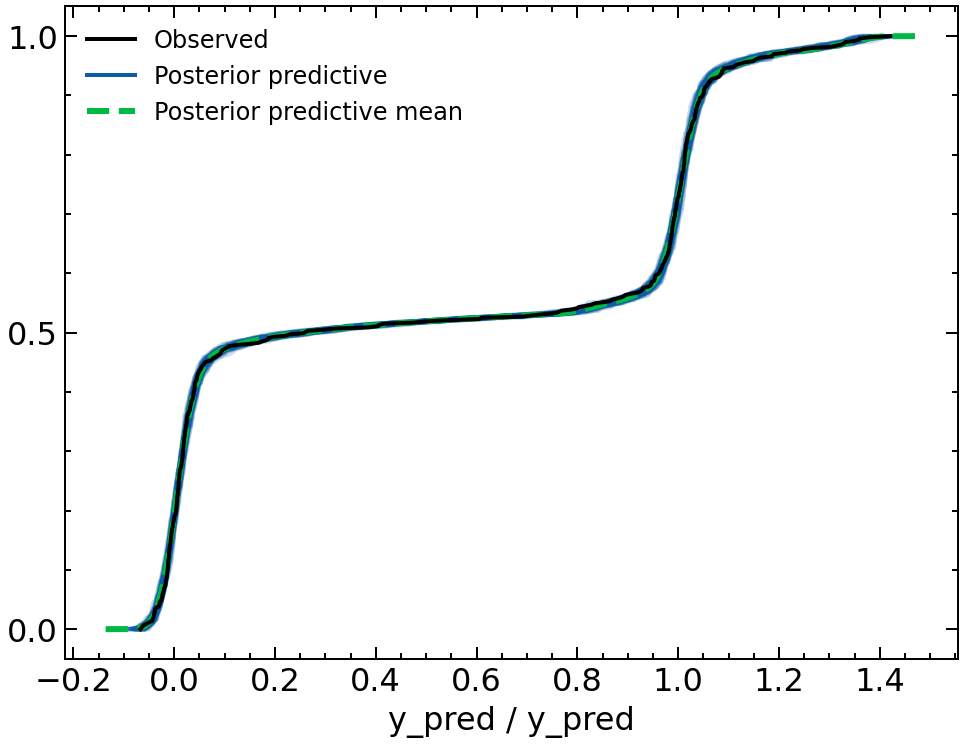

In [35]:
az.plot_ppc(idata, num_pp_samples=100, kind='cumulative')

<AxesSubplot:>

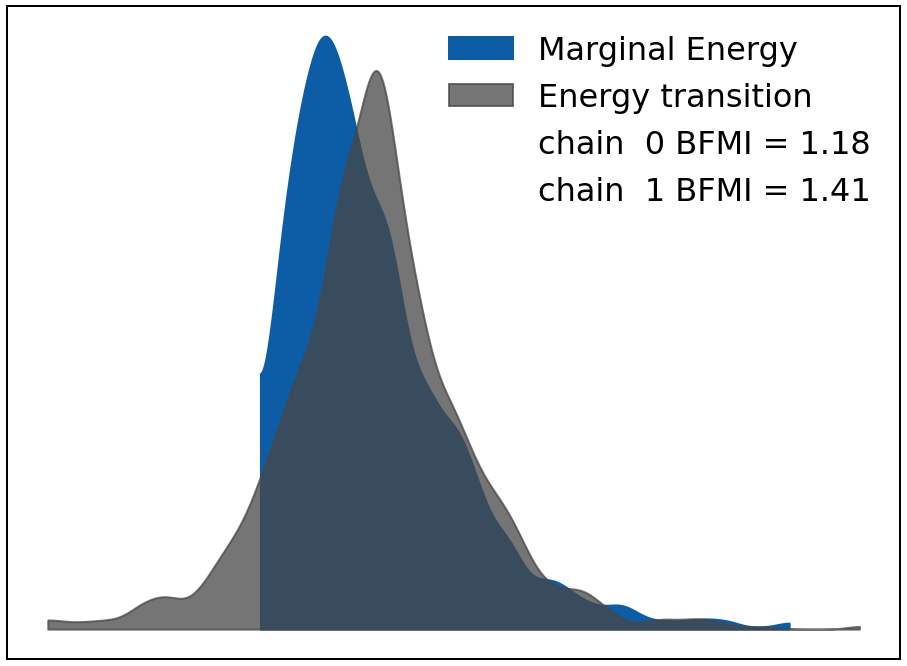

In [36]:
az.plot_energy(idata)